# Object detection practice using Region Proposal Network

This is a tutorial using region proposal network to detect lung in chest X-ray. The ground truth bounding box is generated from the lung segmentation.<br>
The dataset is from https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

Data source: National Library of Medicine, National Institutes of Health, Bethesda, MD, USA and Shenzhen No.3 People’s Hospital, Guangdong Medical College, Shenzhen, China<br>
Publications on this data:<br>
[1] Jaeger S, et al. Automatic tuberculosis screening using chest radiographs. IEEE Trans Med Imaging. 2014 Feb;33(2):233-45.<br>
[2] Candemir S, et al. Lung segmentation in chest radiographs using anatomical atlases with nonrigid registration. IEEE Trans Med Imaging. 2014 Feb;33(2):577-90.

#### The Region Proposal Network (RPN) is the backbone for modern object detection networks. It outputs a list of bounding boxes, with the probability of an object exists in each bounding box. Compared to classification, detection gives the location of objects; compared to segmentation, detection only needs very simple label (bounding boxes) to train, rather than a semantic segmentation. 

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import numpy as np
from IPython import display

In [1]:
# functions including drawing, generate bounding boxes, etc.
def Display(img, probs, bboxes, nMax=10, vmin=0, vmax=250, showText = True, color = 'r'):
    if probs is None:
        probs = np.ones([len(bboxes)], np.float32)
    
    plt.imshow(img, 'gray', vmin=vmin, vmax=vmax)
    if len(probs) > nMax:
        probs = probs[:nMax]
        bboxes = bboxes[:nMax]
    
    for prob, bbox in zip(probs, bboxes):
        rect = patches.Rectangle([bbox[0],bbox[1]], bbox[2], bbox[3], linewidth=1, edgecolor=color, facecolor='none', clip_on = False)
        plt.gca().add_patch(rect)
        if showText:
            plt.text(bbox[0]+6,bbox[1]-6, '%.3f'%prob, color='w', bbox=dict(facecolor=color, alpha=0.5))


# In[3]:


# calculate the intersection over union for bboxes over target
# target - a bounding box of [x,y,width,height]
# bboxes - a list of bounding boxes, each with [x,y,width,height]
def IoU(target, bboxes):
    bboxes = np.array(bboxes)
    
    # calculate intersection
    startX = np.maximum(bboxes[...,0], target[0])
    endX = np.minimum(bboxes[...,0] + bboxes[...,2], target[0] + target[2])
    startY = np.maximum(bboxes[...,1], target[1])
    endY = np.minimum(bboxes[...,1] + bboxes[...,3], target[1] + target[3])
    
    indX = np.where(endX < startX)
    endX[indX] = startX[indX]
    
    indY = np.where(endY < startY)
    endY[indY] = startY[indY]
    
    intersections = (endX - startX) * (endY - startY)
    
    # calculate union = A + B - A^B
    unions = bboxes[...,2] * bboxes[...,3] + target[2] * target[3] - intersections
    
    return intersections / unions


# In[10]:


# generate the raw bboxes for all the anchors
# imgWidth, imgHeight - the width and height of the images
# stepX, stepY - steps of the anchor centers along x and y directions
# anchorWidths, anchorHeights - list of widths and heights of each anchor
# return - bboxes with the shape of [nAnchors, nx, ny, 4], each bbox is [x, y, width, height]
def GetAnchorBBoxes(imgWidth, imgHeight, stepX, stepY, anchorWidths, anchorHeights):
    # get list of centers
    centerXs = np.arange(stepX//2, imgWidth, stepX)
    centerYs = np.arange(stepY//2, imgHeight, stepY)
    centerXs, centerYs = np.meshgrid(centerXs, centerYs)
    
    bboxes = np.zeros([len(anchorWidths), len(centerXs), len(centerYs), 4], np.float32)
    
    # each anchor
    for i in range(len(anchorWidths)):
        bboxes[i, ..., 0] = centerXs - anchorWidths[i] // 2
        bboxes[i, ..., 1] = centerYs - anchorHeights[i] // 2
        bboxes[i, ..., 2] = anchorWidths[i]
        bboxes[i, ..., 3] = anchorHeights[i]
    
    return bboxes


# In[11]:


# get the classification and regression labels for each pixel
# bboxes - all the anchor bounding boxes, in the shape [anchors, nx, ny, 4]
# targets - list of target bounding boxes
# iouThLow - below this threshold the pixel is negative
# iouThHigh - above this threshold the pixel is positive
# return - 
#    clsLabels - classification labels in the shape [nx, ny, anchors]
#    regLabels - regression labels in the shape [nx, ny, anchors * 4]. The arrangement for the least dimension is [x1,y1,w1,h1,x2,y2,w2,h2,...]
# 
# The regression labels are 
#    (x - xa) / wa, (y - ya) / ha, log(w / wa), log(h / ha)
def GetPixelLabels(bboxes, targets, iouThLow = 0.3, iouThHigh = 0.7):
    if len(targets) == 0:
        return (np.zeros([bboxes.shape[1], bboxes.shape[2], bboxes.shape[0]], np.float32), 
    np.zeros([bboxes.shape[1], bboxes.shape[2], bboxes.shape[0] * 4], np.float32))
    
    ious = []
    for target in targets:
        ious.append(IoU(target, bboxes))
    
    ious = np.array(ious)
    inds = np.argmax(ious, 0)    
    
    # calculate the label for regression
    regLabels = np.zeros(list(ious.shape) + [4], np.float32)
    # first calculate the regression labels for all the targets
    for iTarget in range(len(targets)):
        regLabels[iTarget, ..., 0] = (targets[iTarget][0] - bboxes[..., 0]) / bboxes[..., 2]
        regLabels[iTarget, ..., 1] = (targets[iTarget][1] - bboxes[..., 1]) / bboxes[..., 3]
        regLabels[iTarget, ..., 2] = np.log(targets[iTarget][2] / bboxes[..., 2])
        regLabels[iTarget, ..., 3] = np.log(targets[iTarget][3] / bboxes[..., 3])
    # then for each target, select the one with max iou
    inds = np.tile(inds[...,np.newaxis], (1,1,1,regLabels.shape[-1])).flatten()
    y = regLabels.reshape(len(targets), -1)
    y = y[inds, np.arange(len(inds))]
    regLabels = y.reshape(regLabels.shape[1:])
    # switch the axis and merge the last two axises
    regLabels = regLabels.transpose((1,2,0,3))
    regLabels = regLabels.reshape((regLabels.shape[0], regLabels.shape[1], -1))
    
    # calculate the label for classification
    ious = np.max(ious, 0)
    maxIoU = np.max(ious)
    clsLabels = np.zeros_like(ious) - 1         # default -1 means not significant
    clsLabels[ious < iouThLow] = 0              # < iouThLow means negative samples
    clsLabels[ious >= iouThHigh] = 1            # >= iouThHigh means positive samples
    clsLabels[ious >= maxIoU] = 1               # also set the one with max IoU as positive sample
    clsLabels = clsLabels.transpose((1,2,0))    # put the anchors to the channel dimension
    
    return clsLabels, regLabels


# In[12]:


# restore the bounding boxes from regression predictions / labels
# regs - the regression predictions in the shape of [nx, ny, nAnchors * 4]
# anchorBBoxes - the bboxes from anchors, in the shape of [nAnchors, nx, ny, 4]
# return - bounding boxes with reshape [nAnchors, nx, ny, 4]
def GetBBoxFromPreds(regs, bboxes):
    regs = np.copy(regs)
    
    regs = regs.reshape((regs.shape[0], regs.shape[1], -1, 4))
    regs = regs.transpose((2, 0, 1, 3))
    
    regs[..., 0] = regs[..., 0] * bboxes[..., 2] + bboxes[..., 0]
    regs[..., 1] = regs[..., 1] * bboxes[..., 3] + bboxes[..., 1]
    regs[..., 2] = np.exp(regs[..., 2]) * bboxes[..., 2]
    regs[..., 3] = np.exp(regs[..., 3]) * bboxes[..., 3]
    
    return regs


# In[13]:


def NMS(probs, bboxes, iouTh = 0.7):
    targets = []
    targetProbs = []
    candidates = list(bboxes)
    while (len(candidates) > 0):
        ind = np.argmax(probs)
        targets.append(candidates[ind])
        targetProbs.append(probs[ind])
        probs = [probs[i] for i in range(len(candidates)) if i != ind]
        candidates = [candidates[i] for i in range(len(candidates)) if i != ind]
        if len(candidates) == 0:
            break
        
        ious = IoU(targets[-1], candidates)
        probs = [probs[i] for i in range(len(ious)) if ious[i] < iouTh]
        candidates = [candidates[i] for i in range(len(ious)) if ious[i] < iouTh]
    
    return targets, targetProbs


In [0]:
%%capture
!wget -O coords.npy https://www.dropbox.com/s/a7zunr4obd925w7/coords.npy?dl=0
!wget -O imgs.npy https://www.dropbox.com/s/lt6cnufvlcir6p3/imgs.npy?dl=0
!wget -O weights.h5 https://www.dropbox.com/s/pgxhmg0co8ibf12/weights.h5?dl=0

In [0]:
# parameters
srcDir = './'          # directory for data, including images, coodrinates and labels
outDir = './train/'    # directory to save images
checkPoint = None      # check point to restore from. Set None for random initialization
# checkPoint = './weights.h5'   # weights.h5 is a check point after 100 epochs

nTrain = 500            # number of training: starting from the begining of the dataset
nTest = 98            # number of testing: starting from the end of the dataset

device = 0              # gpu device to use
nEpochs = 20            # number of epochs to train, use larger epochs for better and more robust results

# normalization parameters
# img = img / imgNorm + imgOffset, so that the major part of image values is between [-1, 1]
imgNorm = 125
imgOffset = -1

# RPN parameters
anchorWidths = [60, 80, 100]           # width of all the anchors
anchorHeights = [100, 160, 200]        # height of all the anchors
regWeight = 10                         # weight of the regularization term

# network parameters
# a resnet structure is used here
nFilters = 64                          # number of filters for the first block
nBlocks = 4                            # number of residual blocks
lr = 1e-3                              # suggesting using a smaller lr if resume from existing checkpoint
batchSize = 10                         # how many images are trained as a batch
nMaxPosSamples = 256                   # maximum number of positive anchors to be considered in one batch training. The negative anchors will be kept the same number

# IoU thresholds
iouThLow = 0.3         # anchors with lower IoU will be considered negative
iouThHigh = 0.7        # anchors with higher IoU will be considered positive
iouThNMS = 0.2         # bounding boxes with IoU higher than this will be non-maximum suppress. As lungs do not overlap, lower iouThNMS will help reduce FP
iouThTest = 0.5        # bounding boxes with IoU against ground truth higher than this will be considered hit

## Load Data
Let's first load data and investigate it a little bit

In [0]:
# load data
imgs = np.load(os.path.join(srcDir, 'imgs.npy'))
coords = np.load(os.path.join(srcDir, 'coords.npy'))

# shuffle: to make the data evenly distributed in the training and testing dataset
np.random.seed(0)                                  # we use a fixed random seed to make sure the results can be replicated
inds = np.random.permutation(imgs.shape[0])
imgs = imgs[inds, ...]
coords = coords[inds,...]

# the first nTrain images are training images, the last nTest images are testing images
trainImgs = imgs[:nTrain, ...]
testImgs = imgs[-nTest:, ...]
trainCoords = coords[:nTrain, ...]
testCoords = coords[-nTest:, ...]

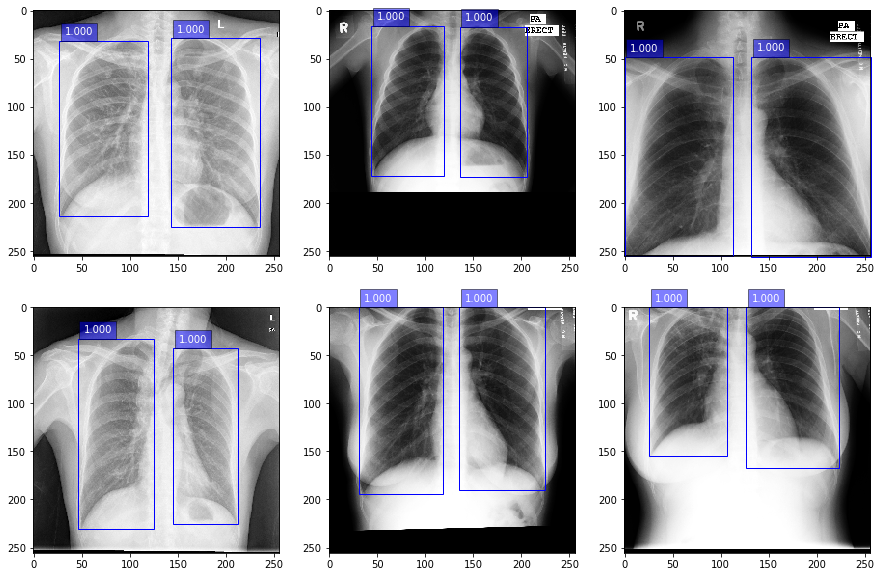

In [7]:
# display 6 random images
np.random.seed(0)
inds = np.random.choice(nTrain, 6)

plt.figure(figsize=[15,10])
for i, ind in enumerate(inds):
    plt.subplot(2,3,i+1)
    Display(imgs[ind,...], None, coords[ind], color='b')

#### As you can see, the task of RPN is to predict those blue bounding boxes of lung.

## Generate labels
RPN is a fully convolutional network, which outputs an 2d prediction map sparsely sampled on the original images. At each sampling position, it ouputs two parts: __probability of the presence of an object and its bounding boxes__.

The bounding box RPN outputs is the relative bounding box, given that the bounding box is $(x,y,w,h)$, the RPN output is<br>
#### $(\frac{x-x_a}{w_a}, \frac{y-y_a}{h_a}, log(\frac{w}{w_a}), log(\frac{h}{h_a}))$<br>
where $(x_a,y_a,w_a,h_a)$ is the correpsonding __anchor's__ bounding box.

Anchors can be considered as reference regions for multi-resolution analysis to consider different sizes of bounding boxes.

In [0]:
# generate labels for all the pixels required by RPN
# First get all the anchors
# anchors is of shape [nAnchors, nx, ny, 4], it is sparsely sampled on the images with nx * ny samples points in total. Each sample point has three anchors on it. 
# The bounding box [x,y,w,h] of each anchor is recorded
anchors = GetAnchorBBoxes(imgs.shape[1], imgs.shape[2], 2**nBlocks, 2**nBlocks, anchorWidths, anchorHeights)

In [0]:
# step 2: get all the labels
#
# clsLabels is of shape [nImgs, nx, ny, nAnchors], 
# each element in clsLabels is corresponding to an anchor, with one of values: -1, 0, 1
# -1 means that the anchor is neither positive or negative (between iouThLow and iouThHigh)
# 0 means that the anchor is negative
# 1 means that the anchor is positive
#
# regLabels is of shape [nImgs, nx, ny, 4 * nAnchors], with the last dimension organized as [x1, y1, w1, h1, x2, y2, ...]
# It records the value needed for regression loss, which is normalized and converted to realtive coordinates:
#    [(x-xa) / wa, (y-ya) / ha, log(w / wa), log(h / ha)]
# where (xa,ya,wa,ha) is the bbox of the anchor, (x,y,w,h) is the ground truth bbox that has the highest IoU with the anchor
# 
clsLabels = []
regLabels = []
for i in range(imgs.shape[0]):
    clsLabel, regLabel = GetPixelLabels(anchors, coords[i])
    
    clsLabels.append(clsLabel)
    regLabels.append(regLabel)

clsLabels = np.array(clsLabels)
regLabels = np.array(regLabels)

Text(0.5, 1.0, '50 random negative anchors')

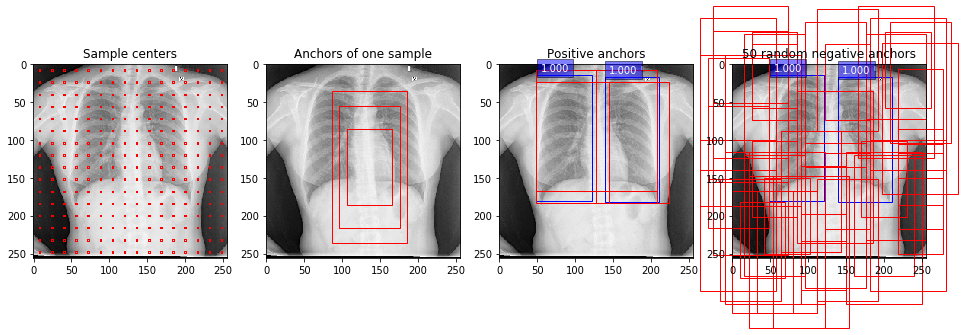

In [0]:
# some visualization of all the anchors
plt.figure(figsize=[16,4])

# figure 1: show the central sample points of all the anchors
centerPoints = np.copy(anchors).reshape((-1, 4))
centerPoints[:, 0] = centerPoints[:, 0] + centerPoints[:, 2] // 2 - 1
centerPoints[:, 1] = centerPoints[:, 1] + centerPoints[:, 3] // 2 - 1
centerPoints[:, 2] = 2
centerPoints[:, 3] = 2
plt.subplot(141)
Display(imgs[0,...], None, centerPoints, 100000, showText=False)
plt.title('Sample centers')

# figure 2: show the anchors of one sample point
plt.subplot(142)
Display(imgs[0,...], None, anchors[:, 8, 8, :], showText=False)
plt.title('Anchors of one sample')

# figure 3: show all the positive anchors
posInds = np.where(clsLabels[0] == 1)
posAnchors = anchors[posInds[2], posInds[0], posInds[1], :]
plt.subplot(143)
Display(imgs[0,...], None, coords[0], color='b')
Display(imgs[0,...], None, posAnchors, showText=False)
plt.title('Positive anchors')

# figure 4: show all the negative anchors
negInds = np.where(clsLabels[0] == 0)
negAnchors = anchors[negInds[2], negInds[0], negInds[1], :]
inds = np.random.choice(negAnchors.shape[0], 50)
plt.subplot(144)
Display(imgs[0,...], None, coords[0], color='b')
Display(imgs[0,...], None, negAnchors[inds,:], 50, showText=False)
plt.title('50 random negative anchors')

#### As you can see, we sampled 16x16 grid on the images, each sample points has 3 anchors at different resolutions. An anchor is considered positive if it has large IoU with ground truth bounding box, then the point and corresponding anchor will be trained to predict the bounding box. 

#### Negative anchors are those who has low IoU with ground truth. Any anchors between low and high are ignored during training.

## Network
We implemented a simple ResNet as the structure for our RPN.

In [0]:
# Config keras
K.clear_session()
sess = tf.Session(config = tf.ConfigProto(gpu_options = tf.GPUOptions(visible_device_list = '%d'%device, allow_growth=True)))
K.set_session(sess)

In [0]:
# cross entropy with mask, which is passed from y_true
# y_true - ground truth, with shape [batch, nx, ny, 2 * nAnchors], y_true[..., :nAnchors] is the labels, y_true[..., nAnchors:] is the mask
# y_pred - network prediction, with shape [batch, nx, ny, nAnchors]
def MaskedCrossEntropy(y_true, y_pred):
    labels = y_true[..., :nAnchors]
    mask = y_true[..., nAnchors:]
    
    return K.sum(mask * K.binary_crossentropy(labels, y_pred)) / K.sum(mask)

# smooth L1 with mask, which is passed from y_true
# y_true - ground truth, with shape [batch, nx, ny, 2 * 4 * nAnchors], y_true[..., :4*nAnchors] is the labels, y_true[..., 4*nAnchors:] is the mask
# y_pred - network prediction, with shape [batch, nx, ny, 4*nAnchors]
def MaskedSmoothL1(y_true, y_pred):
    labels = y_true[..., :4*nAnchors]
    mask = y_true[..., 4*nAnchors:]
    
    
    x = K.abs(labels - y_pred)
    x = K.switch(x < 1, 0.5 * x ** 2, x - 0.5)
    
    return K.sum(mask * x) / K.sum(mask)

In [0]:
# build network
nAnchors = len(anchorWidths)
modelInput = keras.Input((imgs.shape[1], imgs.shape[2], 1))

# first convolutional layer
x = keras.layers.Conv2D(nFilters, 3, padding='same', activation='relu')(modelInput)

# residual modules
for iBlock in range(nBlocks):
    x0 = x
    x = keras.layers.Conv2D(nFilters * (2**iBlock), 3, padding='same')(x)
    x = keras.layers.BatchNormalization(scale = False)(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(nFilters * (2**iBlock), 3, padding='same')(x)
    x = keras.layers.BatchNormalization(scale = False)(x)
    x0 = keras.layers.Conv2D(nFilters * (2**iBlock), 1, padding='same')(x0)
    x = keras.layers.Add()([x, x0])
    x = keras.layers.ReLU()(x)
    
    x = keras.layers.MaxPooling2D(padding='same')(x)

# final layer
x = keras.layers.Conv2D(nFilters * (2**(nBlocks - 1)), 3, padding='same', activation='relu')(x)

# conver to predictions
# outputProb is the probability of a pneumonia presenting for each anchor
# outputBox is the bounding box for each anchor, [x, y, width, height]
nAnchors = len(anchorWidths)
outputProb = keras.layers.Conv2D(nAnchors, 1, activation='sigmoid')(x)
outputReg = keras.layers.Conv2D(4 * nAnchors, 1)(x)

# compile model
model = keras.Model(inputs = modelInput, outputs = [outputProb, outputReg])
model.compile(optimizer = keras.optimizers.Adam(lr = lr), 
              loss = [MaskedCrossEntropy, MaskedSmoothL1], 
              loss_weights = [1, regWeight])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
if checkPoint is not None:
    model.load_weights(checkPoint)

In [0]:
if not os.path.exists(outDir):
    os.makedirs(outDir)

## Training code
There are much more negatives than positives in detection, so we want to balance the two classes for our training. We are choosing to calculate losses only on part of the outputs, so masks has to be generated for each batch. Hence, instead of model.fit(), we mannually feed each batch using model.train_on_batch()

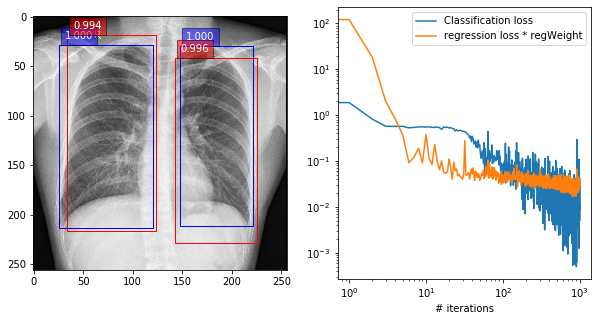

In [0]:
# training code
# because the mask is dynamically generated and has to be balanced, we use train_on_batch function here for mannual training
np.random.seed(0)
losses = []
for epoch in range(nEpochs):
    # re-arrange imgs
    indImgs = np.random.permutation(nTrain)
    
    for batchStart in range(0, len(indImgs), batchSize):
        iImgs = indImgs[batchStart:batchStart + batchSize]
        
        batchImgs = np.copy(trainImgs[iImgs, ...])[..., np.newaxis]
        batchClsLabels = np.copy(clsLabels[iImgs, ...])
        batchRegLabels = np.copy(regLabels[iImgs, ...])
        
        # make same amount of positive and negative samples
        # make mask for positive samples
        posMask = np.zeros_like(batchClsLabels)
        posCoords = np.where(batchClsLabels == 1)
        if len(posCoords[0]) > nMaxPosSamples:
            inds = np.random.choice(len(posCoords[0]), nMaxPosSamples, replace=False)
            posCoords = [p[inds] for p in posCoords]
        posMask[tuple(posCoords)] = 1
        
        # make mask for both negative and positive samples
        negCoords = np.where(batchClsLabels == 0)
        inds = np.random.choice(len(negCoords[0]), len(posCoords[0]), replace = False)
        negCoords = [n[inds] for n in negCoords]
        allMask = np.copy(posMask)
        allMask[tuple(negCoords)] = 1

        # make training labels: the masks are concatenated to labels to pass into keras loss function
        # classification loss use mask for both positive and negative samples
        # regression loss use mask for only positive samples
        posMask = np.tile(posMask[...,np.newaxis], (1,1,1,1,4)).reshape(list(posMask.shape[:-1]) + [-1])
        batchClsLabels = np.concatenate((batchClsLabels, allMask), -1)
        batchRegLabels = np.concatenate((batchRegLabels, posMask), -1)
        batchImgs = batchImgs / imgNorm + imgOffset    # image value normalization
        
        # train for one batch
        loss = model.train_on_batch(batchImgs, [batchClsLabels, batchRegLabels])
        losses.append(loss)
        
        if (batchStart // batchSize + 1) % 10 == 0:
            print ('Epoch = %d, batch = %d, clsLoss = %g, regLoss * regWeight = %g'%(epoch, batchStart // batchSize, loss[1], loss[2] * regWeight))
    
    model.save_weights(os.path.join(outDir, 'tmp.h5'))
    
    display.clear_output()
    
    # test
    iImg = np.random.randint(nTest)
    testImg = testImgs[[iImg], ..., np.newaxis] / imgNorm + imgOffset
    clsPreds, regPreds = model.predict(testImg)                                # get pixelwise prediction
    bboxPreds = GetBBoxFromPreds(regPreds[0,...], anchors)                     # convert the bbox predictions to bounding box in the images
    clsPreds = clsPreds[0,...].transpose((2,0,1))                              # re-arrange classification predictions to nms dimensions

    # threshold out those who has too low probability
    inds = np.where(clsPreds > 0.5)
    clsValid = clsPreds[inds[0], inds[1], inds[2]]
    bboxValid = bboxPreds[inds[0], inds[1], inds[2], :]

    # non-maximum suppression
    nmsBoxes, nmsProb = NMS(clsValid, bboxValid, iouThNMS)

    plt.figure(figsize=[10,5])
    plt.subplot(121)
    Display(testImgs[iImg, ...], None, testCoords[iImg], color='b')
    Display(testImgs[iImg, ...], nmsProb, nmsBoxes, nMax = len(nmsBoxes), showText=True)
    plt.subplot(122)
    displayLosses = np.array(losses)
    plt.loglog(displayLosses[:, 1])
    plt.loglog(displayLosses[:, 2] * regWeight)
    plt.legend(['Classification loss', 'regression loss * regWeight'])
    plt.xlabel('# iterations')
    
    plt.show()
model.save_weights(os.path.join(outDir, 'model.h5'))
np.save(os.path.join(outDir, 'loss'), losses)

## Testing
First let's take a look at the testing procedure

Text(0.5, 1.0, 'Bounding boxes after NMS')

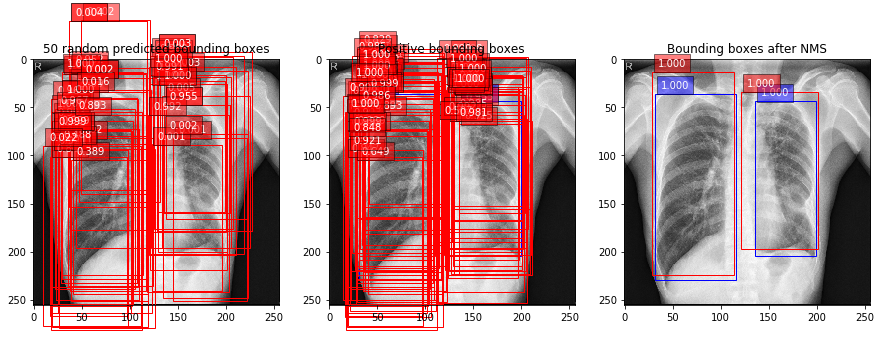

In [0]:
# a visualization of the prediction process
testImg = testImgs[[0], ..., np.newaxis] / imgNorm + imgOffset
clsPreds, regPreds = model.predict(testImg)
bboxPreds = GetBBoxFromPreds(regPreds[0,...], anchors)
clsPreds = clsPreds[0,...].transpose((2,0,1))

plt.figure(figsize=[15,5])
# figure 1: show 50 random predicted bounding boxes
plt.subplot(131)
showPreds = clsPreds.reshape(-1)
showBBox = bboxPreds.reshape(-1, 4)
inds = np.where(showPreds > 0.001)
showPreds = showPreds[inds]
showBBox = showBBox[inds]
inds = np.random.choice(len(showPreds), 50)
Display(testImgs[0,...], showPreds[inds], showBBox[inds, :], 50)
plt.title('50 random predicted bounding boxes')

# figure 2: show positive predicted bounding boxes
inds = np.where(clsPreds > 0.5)
clsValid = clsPreds[inds[0], inds[1], inds[2]]
bboxValid = bboxPreds[inds[0], inds[1], inds[2], :]
plt.subplot(132)
Display(testImgs[0, ...], None, testCoords[0], color='b')
Display(testImgs[0,...], clsValid, bboxValid, 10000)
plt.title('Positive bounding boxes')

# figure 3: show after NMS
nmsBoxes, nmsProb = NMS(clsValid, bboxValid, iouThNMS)
plt.subplot(133)
Display(testImgs[0, ...], None, testCoords[0], color='b')
Display(testImgs[0,...], nmsProb, nmsBoxes)
plt.title('Bounding boxes after NMS')

#### Explain each step:
#### 1. Each sample point will output three bounding boxes with different probability.
#### 2. A threshold on probability will remove some of the bounding boxes.
#### 3. Non-maximum suppressing (NMS) will remove overlapping boxes.

In [0]:
# test on the testing set
testProbs = []
testBBoxes = []
for iTest in range(nTest):
    if (iTest + 1) % 10 == 0:
        print (iTest, end=',')
    testImg = testImgs[[iTest], ..., np.newaxis] / imgNorm + imgOffset
    clsPreds, regPreds = model.predict(testImg)
    bboxPreds = GetBBoxFromPreds(regPreds[0,...], anchors)
    clsPreds = clsPreds[0,...].transpose((2,0,1))

    inds = np.where(clsPreds > 0.5)
    clsValid = clsPreds[inds[0], inds[1], inds[2]]
    bboxValid = bboxPreds[inds[0], inds[1], inds[2], :]

    nmsBoxes, nmsProb = NMS(clsValid, bboxValid, iouThNMS)
    
    testProbs.append(np.array(nmsProb))
    testBBoxes.append(np.array(nmsBoxes))

9,19,29,39,49,59,69,79,89,

## Evaluation
Finally, let us calculate some Free response ROC (FROC) for our results as the conclusion for this tutorial

In [0]:
# calculate the IoU of testBBoxes and ground truth
ious = []
for iTest in range(nTest):
    currentIoU = []
    
    for coord in testCoords[iTest]:
        if len(testBBoxes[iTest]) == 0:
            currentIoU.append([0])    # if no bounding box is detected, assign a "virtual" bbox with 0 IoU
        else:
            currentIoU.append(IoU(coord, testBBoxes[iTest]))
    currentIoU = np.array(currentIoU)

    ious.append(currentIoU)

In [0]:
# calculate the FROC curve
def CalcSensitivityAndFP(probs, ious, probTh, iouTh):
    fp = 0
    hit = 0
    for prob, iou in zip(probs, ious):
        if len(prob) == 0:
            prob = [0]

        iou = np.where(iou > iouTh, 1, 0)
        prob = np.where(np.array(prob) > probTh, 1, 0)
        
        # fp: iou is negative but prob is positive
        fpVal = prob - np.max(iou, 0)
        fpVal[fpVal < 0] = 0
        fp += np.sum(fpVal)
        
        # hit: prob > th and iou > iouTh
        prob = np.tile(prob[np.newaxis, ...], (iou.shape[0], 1))
        hit += np.max(iou * prob, 1).sum()
        
    return hit, fp

In [0]:
decisionThreshes = 1 - np.array([0.5, 0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])
totalCounts = testCoords.shape[0] * testCoords.shape[1]
fps = []
senses = []
for th in decisionThreshes:
    hit, fp = CalcSensitivityAndFP(testProbs, ious, th, iouThTest)
    fps.append(fp / testCoords.shape[0])
    senses.append(hit / totalCounts)

Text(0, 0.5, 'Sensitivity')

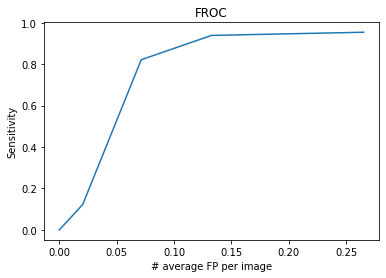

In [0]:
plt.plot(fps, senses)
plt.title('FROC')
plt.xlabel('# average FP per image')
plt.ylabel('Sensitivity')

#### We have a very high sensitivity and low FP rate, Good work!